In [1]:
import os
import sys
sys.path.append("helpers")
import helpers.helpers as helpers

from DQTools.dataset import Dataset
from helpers.smoothn import smoothn

import xarray as xr
import numpy as np

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import pandas as pd
import ipywidgets as widgets
from ipywidgets import HBox

from IPython.display import clear_output
from IPython.display import display
from IPython.lib.display import FileLink

In [2]:
farms = pd.read_csv('data/WeatherStationsFarms.csv', header=1)

farms_subset = farms[['STATION_ID','FARMER NAME']]
farms_subset_list = farms_subset.values.tolist()

In [3]:
product = 'era5'
subproduct = 't2m'

fig, (ax, bx) = plt.subplots(2, 1, sharex=True, sharey=True)
fig.set_size_inches(9.0, 7.0)

def get_adjusted_data_from_geopot_height(data, elevation):
   
    # Elevation derived from ERA5 surface geopotential (m)
    elev_geopotential = 2078
    # Temperature rate of change when elevation increases (°C/m)
    temp_rate = -0.0065

    getattr(data, subproduct).data -= ((elev_geopotential-elevation) * temp_rate)
    
    return data

def get_data_from_datacube(product, subproduct, start, end,
                           latitude, longitude):

    keyfile = os.path.join(os.path.expanduser("~"), 'assimila_dq.txt')
    
    ds = Dataset(product=product, subproduct=subproduct,
                 key_file=keyfile)

    ds.get_data(start=start, stop=end,
                latlon=[latitude, longitude])
    
    return ds.data

def smooth_time_series(data, threshold=30.0):
    """
    Apply a threshold to mask data and smooth time series
    """
    # Plot a horizontal line
    ax.axhline(y=threshold, linewidth=0.5, color='red', ls='--')
   
    data = data.mask(data > threshold)
    data = data.interpolate()
    
    # Smooth
    s_data = smoothn(data.values, isrobust=True, s=2.0, TolZ=1e-6)[0]
    
    return s_data

def get_station_data(station):
    """
    Get data for a particular station
    """
    fname = f'{station}_averages.csv'
    fname = os.path.join('data', fname)
    
    try:
        data = pd.read_csv(fname)
    except FileNotFoundError as e:
        print(e)
        return None
    
    # Convert GMT date to datetime
    data['date'] = data['date'].astype('datetime64[ns]') 
    
    return data


def on_get_data_click(b):

    # Join data
    df = _merged.to_dataframe(name='adjusted_temp')
    series = _merged_unc.to_dataframe(name='adjusted_temp_unc')['adjusted_temp_unc']

    tmp_df = df.join(series, on='time')
    
    fname = f'{str(dropdown_farms.value)}_merged_temperature.csv'
    
    tmp_df.to_csv(fname)
    localfile = FileLink(fname)
        
    display(localfile)

def on_dropdown_farms_change(change):
    """
    Handles change event on dropdown_farms widget
    """
    if change['type'] == 'change' and change['name'] == 'value':
        ax.clear()
        bx.clear()
        
        farm_data = farms[farms.STATION_ID==dropdown_farms.value]
        
        data = get_station_data(dropdown_farms.value)
        if data is None:
            return None
    
        # Plot original data
        ax.plot(data['date'], data['Air.Temperature_hourly.mean'],
                label='Air.Temperature_hourly.mean', marker='+', lw=0.5, color='C0')
        
        # Plot ERA5 skt data
        start = data['date'].iloc[0].strftime('%Y-%m-%d')
        end = data['date'].iloc[-1].strftime('%Y-%m-%d')
        
        era5_t2m = get_data_from_datacube(product, subproduct,
                        start, end,
                        5.580826, -75.485412)
        # Kelvin to Celcius
        getattr(era5_t2m, subproduct).data = getattr(era5_t2m, subproduct).data - 273.15
        getattr(era5_t2m, subproduct).plot(ax=ax, label=f'{product} - {subproduct}',
                                           lw=0.5, color='C1')
        
        # Apply QA threshold and smooth data
        _smoothed_data = smooth_time_series(data['Air.Temperature_hourly.mean'])
        # Create xarray from smoothed date
        lat = getattr(era5_t2m, subproduct).latitude.data
        lon = getattr(era5_t2m, subproduct).longitude.data
        smoothed_data = xr.DataArray(_smoothed_data,
                                     name = 'Air.Temperature_hourly.mean.QC',
                                     dims=['time'],
                                     coords={'latitude' : lat,
                                             'longitude' : lon,
                                             'time' : data['date']})
        
        smoothed_data.plot(ax=ax, label='Air.Temperature_hourly.mean.QC', color='C0')
                        
        # Get adjusted by geopotential height
        era5_t2m_adjusted = get_adjusted_data_from_geopot_height(
            era5_t2m,
            farm_data['ALTITUDE'].values[0])
        g_era5_t2m_adjusted = era5_t2m_adjusted
        
        getattr(era5_t2m_adjusted, subproduct).plot(ax=ax,
                                                    label=f'{product} - {subproduct} (adjusted)',
                                                    color='C1')
        
        ax.grid()
        ax.set_title(farm_data['FARMER NAME'].values[0])
        ax.legend(loc='best', fontsize='small',
                  fancybox=True, framealpha=0.5)
        
        # Create merged dataset
        global merged
        merged = xr.merge([smoothed_data,
                           getattr(era5_t2m_adjusted, subproduct)])
        
        #getattr(merged, subproduct).plot(ax=bx, label=f'{product} - {subproduct} (adjusted)',
        #                                 color='C1')
        
        #getattr(merged, 'Air.Temperature_hourly.mean.QC').plot(ax=bx,
        #    label=f'Air.Temperature_hourly.mean.QC', color='C0')
        
        #bx.fill_between(getattr(merged, subproduct).time.data,
        #                 getattr(merged, subproduct).data,
        #                 getattr(merged, 'Air.Temperature_hourly.mean.QC').data,
        #                 alpha=0.2)
        
        global _merged
        _merged = (getattr(merged, 'Air.Temperature_hourly.mean.QC') + 
                   merged.t2m) / 2.0
        # Fill NaNs where there is NO in-situ obs
        idx = np.argwhere(np.isnan(_merged.data))
        _merged.data[idx] = merged.t2m.data[idx]
        
        # Uncertainty
        global _merged_unc
        _merged_unc = (getattr(merged, 'Air.Temperature_hourly.mean.QC') - 
                       merged.t2m)
        _merged_unc.data = np.absolute(_merged_unc.data)
        # Nominal uncert
        _merged_unc.data[idx] = merged.t2m.data[idx] * 0.1
        
        # Fill NaNs where there is NO ERA5 data
        idx = np.argwhere(np.isnan(merged.t2m.data))
        times = merged.t2m.time.data[idx]

        start = times[0][0].astype(str)
        end = times[-1][0].astype(str)

        _merged.data[idx[:,0]] = \
        getattr(merged, 'Air.Temperature_hourly.mean.QC').sel(time=slice(start[0:-10], end[0:-10]))

        _merged_unc.data[idx[:,0]] = _merged.data[idx[:,0]] * 0.1
        
        # Plot merged dataset
        _merged.plot(ax=bx, color='C2', label='Merged temperature dataset')
        bx.fill_between(_merged.time.data,
                        _merged.data + _merged_unc.data,
                        _merged.data - _merged_unc.data,
                        alpha=0.2, color='C2')
        
        bx.grid()
        bx.legend(loc='best', fontsize='small',
                  fancybox=True, framealpha=0.5)
        
        get_data.disabled = False
        
        plt.show()


In [4]:
# Dropdown widget with all farms
dropdown_farms = widgets.Dropdown(
    options=farms['STATION_ID'],
    value=farms['STATION_ID'][0],
    description='Farm:',
    disabled=False,
)

dropdown_farms.observe(on_dropdown_farms_change)

get_data = widgets.Button(
    description='Get merged dataset',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    icon='file' # (FontAwesome names without the `fa-` prefix)
)

get_data.on_click(on_get_data_click)

## Farm analytics

Select a farm ID to explore the datasets. Click on 'Get merged data' to get an text file of the merged dataset.

<IPython.core.display.Javascript object>


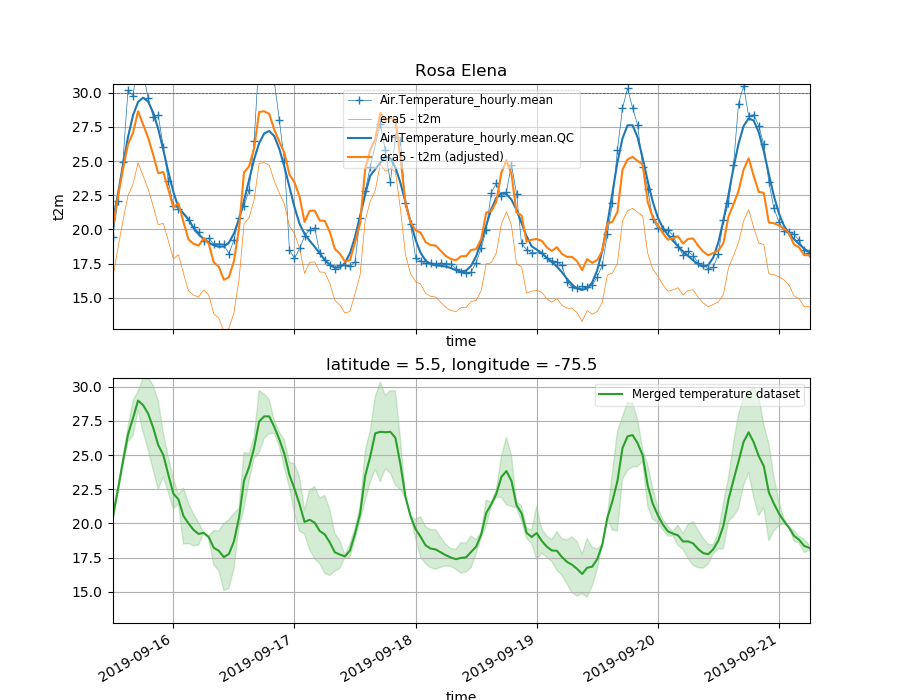

In [5]:
HBox([dropdown_farms, get_data])
#display(dropdown_farms)
#display(get_data)